In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Certificate /BCCD_Dataset.zip"  # Update path if needed
extract_path = "/content/BCCD_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")


Extraction complete.


In [17]:
# List the contents of the extracted dataset directory
dataset_master_path = os.path.join(extract_path, "BCCD_Dataset-master")
os.listdir(dataset_master_path)


['BCCD',
 'plot.py',
 '.gitignore',
 'export.py',
 'example.jpg',
 'scripts',
 'LICENSE',
 'test.csv',
 'README.md',
 'dataset']

In [18]:
# List the contents of the BCCD directory
bccd_path = os.path.join(dataset_master_path, "BCCD")
bccd_files = os.listdir(bccd_path)

# Show the first 10 files
bccd_files[:10]


['Annotations', 'JPEGImages', 'labels', 'ImageSets']

In [19]:
# List image files in the JPEGImages directory
jpeg_images_path = os.path.join(bccd_path, "JPEGImages")
image_files = os.listdir(jpeg_images_path)

# Show the first 10 image files
image_files[:10]


['BloodImage_00279.jpg',
 'BloodImage_00335.jpg',
 'BloodImage_00273.jpg',
 'BloodImage_00283.jpg',
 'BloodImage_00294.jpg',
 'BloodImage_00109.jpg',
 'BloodImage_00158.jpg',
 'BloodImage_00275.jpg',
 'BloodImage_00144.jpg',
 'BloodImage_00293.jpg']

In [20]:
!pip install albumentations


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


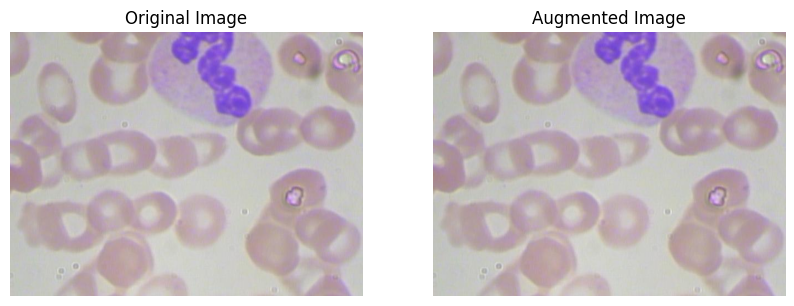

In [21]:
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

# Define augmentation pipeline
augmentations = A.Compose([
    A.RandomRotate90(p=0.5),        # Random 90-degree rotation
    A.HorizontalFlip(p=0.5),        # Random horizontal flip
    A.VerticalFlip(p=0.5),          # Random vertical flip
    A.RandomBrightnessContrast(p=0.5),  # Adjust brightness and contrast
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5)  # Small transformations
])

# Load an image for testing augmentation
sample_image_path = os.path.join(jpeg_images_path, image_files[0])
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Apply augmentation
augmented = augmentations(image=image)['image']

# Display original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(augmented)
ax[1].set_title("Augmented Image")
ax[1].axis("off")

plt.show()


In [22]:
# !pip install ultralytics


In [23]:
import os
import xml.etree.ElementTree as ET

# Define paths
dataset_path = "/content/BCCD_Dataset/BCCD_Dataset-master/BCCD"  # Update path if needed
annotations_dir = os.path.join(dataset_path, "Annotations")
images_dir = os.path.join(dataset_path, "JPEGImages")
yolo_labels_dir = os.path.join(dataset_path, "labels")

# Create YOLO labels directory if it doesn't exist
os.makedirs(yolo_labels_dir, exist_ok=True)

# Class mapping for BCCD dataset
class_mapping = {"RBC": 0, "WBC": 1, "Platelets": 2}

def convert_voc_to_yolo(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_filename = root.find("filename").text
    image_path = os.path.join(images_dir, image_filename)

    # Get image size
    size = root.find("size")
    img_width = int(size.find("width").text)
    img_height = int(size.find("height").text)

    yolo_labels = []

    # Parse object annotations
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        if class_name not in class_mapping:
            continue  # Skip unknown classes
        class_id = class_mapping[class_name]

        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # Convert to YOLO format (normalized values)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Save to .txt file
    txt_filename = os.path.splitext(image_filename)[0] + ".txt"
    txt_filepath = os.path.join(yolo_labels_dir, txt_filename)
    with open(txt_filepath, "w") as f:
        f.write("\n".join(yolo_labels))

# Convert all XML files
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith(".xml"):
        convert_voc_to_yolo(os.path.join(annotations_dir, xml_file))

print(" Conversion complete! YOLO annotations saved in 'labels/' folder.")


 Conversion complete! YOLO annotations saved in 'labels/' folder.


In [24]:
import os
import shutil
import random

# Define dataset paths
dataset_path = "/content/BCCD_Dataset/BCCD_Dataset-master/BCCD"
images_path = os.path.join(dataset_path, "JPEGImages")
labels_path = os.path.join(dataset_path, "labels")  # Assuming YOLO txt files are in 'labels/'

# Define new train/valid folders
output_path = "/content/BCCD_Dataset"
train_images = os.path.join(output_path, "train/images")
valid_images = os.path.join(output_path, "valid/images")
train_labels = os.path.join(output_path, "train/labels")
valid_labels = os.path.join(output_path, "valid/labels")

# Create folders if they don't exist
for folder in [train_images, valid_images, train_labels, valid_labels]:
    os.makedirs(folder, exist_ok=True)

# Get all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(".jpg")]
random.shuffle(image_files)  # Shuffle dataset for randomness

# Split 80% train, 20% validation
split_idx = int(0.8 * len(image_files))
train_files = image_files[:split_idx]
valid_files = image_files[split_idx:]

# Move images and labels
for file_list, img_dest, lbl_dest in [(train_files, train_images, train_labels), (valid_files, valid_images, valid_labels)]:
    for img_file in file_list:
        # Move image
        shutil.move(os.path.join(images_path, img_file), os.path.join(img_dest, img_file))

        # Move corresponding label (txt) if it exists
        label_file = img_file.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(labels_path, label_file)):
            shutil.move(os.path.join(labels_path, label_file), os.path.join(lbl_dest, label_file))

print("Dataset split completed! 'train/' and 'valid/' folders are ready.")


Dataset split completed! 'train/' and 'valid/' folders are ready.


In [25]:
train='/content/BCCD_Dataset/train'  # Path to training images
val='/content/BCCD_Dataset/valid'   # Path to validation images

nc= 3  # Number of classes (for BCCD dataset)

names: ['RBC', 'WBC', 'Platelets']  # Class names


In [26]:
yaml_content = """train: /content/BCCD_Dataset/train/images
val: /content/BCCD_Dataset/valid/images

nc: 3  # Number of classes

names: ['RBC', 'WBC', 'Platelets']  # Class names
"""

# Save dataset.yaml inside /content/BCCD_Dataset/
with open("/content/BCCD_Dataset/dataset.yaml", "w") as f:
    f.write(yaml_content)

print(" dataset.yaml file created successfully!")


 dataset.yaml file created successfully!


In [ ]:
from ultralytics import YOLO

# Load the YOLOv10 model
model = YOLO("/content/yolov10n.pt")  # Ensure the correct path to your model file

# Train the model using the dataset.yaml file
model.train(data="/content/BCCD_Dataset/dataset.yaml", epochs=30, imgsz=640)


Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov10n.pt, data=/content/BCCD_Dataset/dataset.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

train: Scanning /content/BCCD_Dataset/train/labels.cache... 347 images, 0 backgrounds, 0 corrupt: 100%|██████████| 347/347 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/BCCD_Dataset/valid/labels.cache... 129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 129/129 [00:00<?, ?it/s]


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train8
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.22G      2.574      6.575      2.707        307        640: 100%|██████████| 22/22 [00:10<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]

                   all        129       1750     0.0212      0.639      0.233      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.48G      2.417      4.088       2.33        209        640: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        129       1750     0.0224      0.631      0.339      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.48G      2.428      3.153       2.36        273        640: 100%|██████████| 22/22 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]

                   all        129       1750      0.609      0.558      0.464      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.48G      2.338      2.682      2.354        353        640: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]

                   all        129       1750      0.772      0.393      0.462      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.48G      2.319      2.682      2.369        318        640:   9%|▉         | 2/22 [00:00<00:05,  3.81it/s]

In [ ]:
import os

model_path = None

for root, dirs, files in os.walk("/content/runs/detect"):
    for file in files:
        if file.endswith(".pt"):  # Find any YOLO model file
            model_path = os.path.join(root, file)
            print("Model found at:", model_path)

if model_path is None:
    print("No model file found. Check if training completed successfully.")


✅ Model found at: /content/runs/detect/train6/weights/best.pt
✅ Model found at: /content/runs/detect/train6/weights/last.pt



image 1/1 /content/BCCD_Dataset/valid/images/BloodImage_00000.jpg: 480x640 20 RBCs, 1 WBC, 13.0ms
Speed: 2.7ms preprocess, 13.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


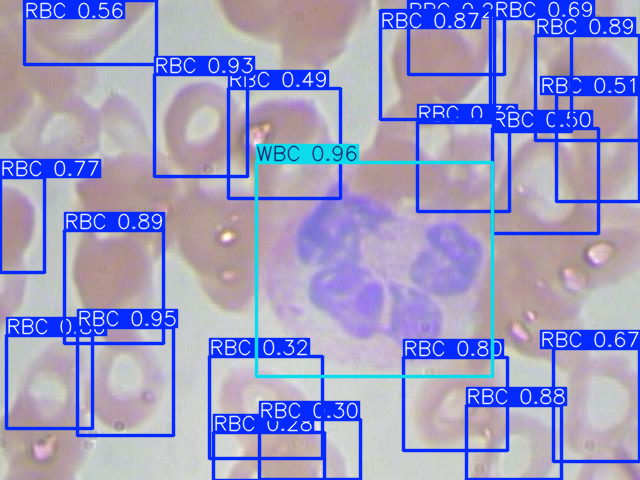

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load trained YOLOv10 model
model = YOLO("/content/runs/detect/train6/weights/best.pt")  # Update with correct path

# Perform inference on an image
image_path = "/content/BCCD_Dataset/valid/images/BloodImage_00000.jpg"  # Ensure this image exists
results = model(image_path)  # YOLO returns a list of results

# Extract the first result
first_result = results[0]

# Display image with bounding boxes
first_result.show()


In [ ]:
import locale
import os

# Set environment variables
os.environ["LC_ALL"] = "en_US.UTF-8"
os.environ["LANG"] = "en_US.UTF-8"

# Manually set the locale
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")

# Verify locale
print(locale.getpreferredencoding())


ANSI_X3.4-1968


In [ ]:
import os
import locale

# Force setting the locale to UTF-8
os.environ["LC_ALL"] = "C.UTF-8"
os.environ["LANG"] = "C.UTF-8"

# Apply the locale
locale.setlocale(locale.LC_ALL, "C.UTF-8")

# Verify the encoding
print(locale.getpreferredencoding())  # Should print UTF-8


ANSI_X3.4-1968
